In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import time
import os

2023-05-28 15:17:28.719399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def restruct_img(img_path,path):
    img = cv2.imread(os.path.join(path,img_path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img_gray, (32,32))
    return img

# loss plot
def draw_plot(name, fig_li):
    #fig = plt.figure(1)	#identifies the figure 
    plt.plot([i for i in range(len(fig_li))], fig_li)
    plt.xlabel("epoch",fontsize='13')
    plt.ylabel(name,fontsize='13')
    plt.grid()
    plt.savefig(f'{name}.png')
    #plt.clf()

def evaluate(Y_pred, Y_True):
        # Top-1
        pred_label = np.argmax(Y_pred, axis=1)
        top1 = round(sum(Y_True == pred_label)/(1.0*len(Y_True)), 4)

        # Top-5
        size = Y_True.shape[0]
        count = 0
        for i in range(size):
            top5 = np.argpartition(Y_pred[i],-5)[-5:]
            if Y_True[i] in top5:
                count += 1
        top5 = round(count/size,4)

        return top1,top5

In [3]:
pre_path = "../image/"
train = 'train.txt'
val = 'val.txt'
test = 'test.txt'
train = pd.read_csv(os.path.join(pre_path, train) , delimiter=" ", header=None)
val = pd.read_csv(os.path.join(pre_path, val), delimiter=" ", header=None)
test = pd.read_csv(os.path.join(pre_path, test), delimiter=" ", header=None)

train.columns = ['image', 'label']
val.columns = ['image', 'label']
test.columns = ['image', 'label']

train['image'] = train['image'].apply(restruct_img,args=(pre_path,))
val['image'] = val['image'].apply(restruct_img,args=(pre_path,))
test['image'] = test['image'].apply(restruct_img,args=(pre_path,))

X_train = np.array(list(train['image'].values))
y_train = np.array(train['label'])
X_val = np.array(list(val['image'].values))
y_val = np.array(val['label'])
X_test = np.array(list(test['image'].values))
y_test = np.array(test['label'])

In [3]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=6, kernel_size=5, strides=1,  activation='tanh', input_shape=(32, 32, 1), padding='valid'), #C1
    keras.layers.MaxPooling2D(), #S2
    keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.MaxPooling2D(), #S4
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(120, activation='tanh'), #F6
    keras.layers.Dense(84, activation='tanh'), #F6
    keras.layers.Dense(50, activation='softmax') #Output layer
    ])
model.summary()
model.compile(optimizer= "adam", loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

2023-05-28 15:17:50.935502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 15:17:50.946957: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0, shuffle=True)

Epoch 1/10
248/248 [==============================] - 40s 156ms/step - loss: 3.6863 - accuracy: 0.0677
Epoch 2/10
248/248 [==============================] - 39s 157ms/step - loss: 3.5042 - accuracy: 0.0975
Epoch 3/10
248/248 [==============================] - 36s 146ms/step - loss: 3.4246 - accuracy: 0.1131
Epoch 4/10
248/248 [==============================] - 37s 148ms/step - loss: 3.3601 - accuracy: 0.1255
Epoch 5/10
248/248 [==============================] - 38s 153ms/step - loss: 3.3220 - accuracy: 0.1338
Epoch 6/10
248/248 [==============================] - 38s 154ms/step - loss: 3.2901 - accuracy: 0.1394
Epoch 7/10
248/248 [==============================] - 37s 151ms/step - loss: 3.2627 - accuracy: 0.1453
Epoch 8/10
248/248 [==============================] - 37s 148ms/step - loss: 3.2360 - accuracy: 0.1508
Epoch 9/10
248/248 [==============================] - 37s 148ms/step - loss: 3.2160 - accuracy: 0.1555
Epoch 10/10
248/248 [==============================] - 36s 145ms/step - l

In [8]:
predict_y = model.predict(X_val)
top1, top5 = evaluate(predict_y, y_val )
print(top1, top5)

predict_y = model.predict(X_test)
top1, top5 = evaluate(predict_y, y_test )
print(top1, top5)

15/15 [==============================] - 0s 17ms/step


(0.1222, 0.4244)

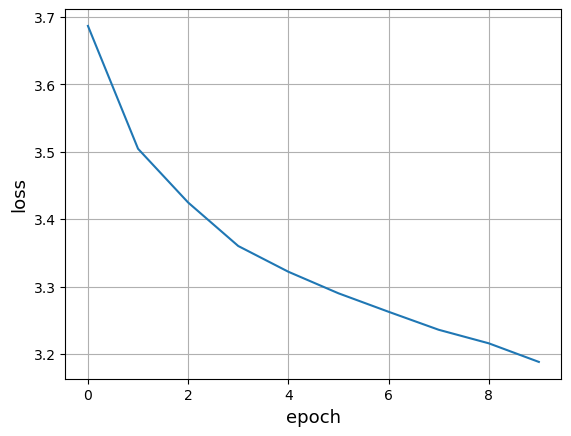

In [6]:
draw_plot("loss", history.history['loss'])